In [1]:
import numpy as np
from scipy.special import comb
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import copy
import pickle
import sys, os

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

font = {'size': 10}
matplotlib.rc('font', **font)
plt.rcParams["font.family"] = 'serif'
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes', labelsize=20)    # fontsize for xlabel and ylabel
matplotlib.rc('axes', titlesize=20)    # fontsize for title
plt.rcParams['legend.fontsize'] = 20

def plot_mean_std(inspect_points, mean, std, label, color, alpha, linestyle='-', marker='.', linewidth=1):
  plt.plot(inspect_points, mean, label=label, color=color, linestyle=linestyle, marker=marker, linewidth=linewidth)
  plt.fill_between(inspect_points, mean+std, mean-std, color=color, alpha=alpha )

In [2]:
def count_misorder(true_lst, arr):
  arr = arr[np.argsort(true_lst)]

  count = 0

  for i in range(len(arr)):
    for j in range(i+1, len(arr)):
      if arr[i] > arr[j]:
        count += 1
  return count


def beta_constant(a, b):
    '''
    the second argument (b; beta) should be integer in this function
    '''
    beta_fct_value=1/a
    for i in range(1,b):
        beta_fct_value=beta_fct_value*(i/(a+i))
    return beta_fct_value


def compute_weight_list(m, alpha=1, beta=1):
    '''
    Given a prior distribution (beta distribution (alpha,beta))
    beta_constant(j+1, m-j) = j! (m-j-1)! / (m-1)! / m # which is exactly the Shapley weights.
    # weight_list[n] is a weight when baseline model uses 'n' samples (w^{(n)}(j)*binom{n-1}{j} in the paper).
    '''
    weight_list=np.zeros(m)
    normalizing_constant=1/beta_constant(alpha, beta)
    for j in np.arange(m):
        # when the cardinality of random sets is j
        weight_list[j]=beta_constant(j+alpha, m-j+beta-1)/beta_constant(j+1, m-j)
        weight_list[j]=normalizing_constant*weight_list[j] # we need this '/m' but omit for stability # normalizing
    return weight_list

# Semivalue Value

In [3]:
# convert 'one-hot value' to set of data indices
def val_to_dataind(v):
  one_hot = np.array([int(x) for x in bin(v)[2:]])[::-1]
  return one_hot.nonzero()[0]

# convert set of data indices to 'one-hot value'
def dataind_to_val(arr):
  val = 0
  for i in arr:
    val += 2**i
  return val

def exact_semivalue(utility_array, n_data, target_ind, weight_func):

  assert len(utility_array) == 2**n_data

  sv = 0
  for v in range(0, 2**n_data):
    ind_set = val_to_dataind(v)
    if target_ind in ind_set:
      pass
    else:
      s = len(ind_set)
      weight = weight_func(n_data, s)
      v_sand = dataind_to_val(list(ind_set)+[target_ind])
      sv += weight*(utility_array[v_sand] - utility_array[v])

  return sv

def exact_shapley(utility_array, n_data, target_ind):
  sv_weight_func = lambda n_data, s: 1/n_data * (1/comb(n_data-1, s))
  return exact_semivalue(utility_array, n_data, target_ind, sv_weight_func)

def exact_banzhaf(utility_array, n_data, target_ind):
  bz_weight_func = lambda n_data, s: 1/(2**(n_data-1))
  return exact_semivalue(utility_array, n_data, target_ind, bz_weight_func)

def exact_betashapley(utility_array, n_data, target_ind, a, b):
  w = compute_weight_list(n_data, alpha=a, beta=b)
  sv_weight_func = lambda n_data, s: w[s] * 1/n_data * (1/comb(n_data-1, s))
  return exact_semivalue(utility_array, n_data, target_ind, sv_weight_func)

# Data Selection

In [4]:
def get_selection_acc(data_value, utility_func, x_train, y_train, x_test, y_test, removal=False):

  n_data = len(data_value)

  ret = []

  if removal:
    rank = np.argsort(data_value) # rank data from low value to high value
  else:
    rank = np.argsort(data_value)[::-1] # rank data from high value to low value

  for i in range(n_data+1):
    if removal:
      ind = rank[i:]
    else:
      ind = rank[:i]

    ind = sorted(ind)
    ret.append( utility_func(x_train[ind], y_train[ind], x_test, y_test) )
  return ret


def get_util_func(x_train, y_train, x_test, y_test, method='LR'):

  n_train = len(y_train)
  utility_array = np.zeros(2**n_train)

  for v in tqdm(range(0, 2**n_train)):
    ind = val_to_dataind(v)
    ind = sorted(ind)
    if method == 'LR':
      utility_array[v] = sklearn_logistic_data_to_acc(x_train[ind], y_train[ind], x_test, y_test)
    elif method == 'SVM':
      utility_array[v] = sklearn_svm_data_to_acc(x_train[ind], y_train[ind], x_test, y_test)
  return utility_array

# Experiment: Construct alternative utility function that achieves the same KNN-Shapley

In [5]:
def rank_neighbor(x_test, x_train, dis_metric='l2'):
  if dis_metric == 'cosine':
    distance = -np.dot(x_train, x_test) / np.linalg.norm(x_train, axis=1)
  else:
    distance = np.array([np.linalg.norm(x - x_test) for x in x_train])
  return np.argsort(distance)


# x_test, y_test are single data point
def knn_shapley_RJ_single(x_train_few, y_train_few, x_test, y_test, K, dis_metric='cosine'):

  N = len(y_train_few)
  sv = np.zeros(N)
  rank = rank_neighbor(x_test, x_train_few, dis_metric = dis_metric)
  sv[int(rank[-1])] += int(y_test==y_train_few[int(rank[-1])]) / N

  for j in range(N-2, -1, -1):
    sv[int(rank[j])] = sv[int(rank[j+1])] + (
      int(y_test==y_train_few[int(rank[j])]) - 
      int(y_test==y_train_few[int(rank[j+1])])
    ) / max(K, j+1)
  return sv


# Original KNN-Shapley proposed in http://www.vldb.org/pvldb/vol12/p1610-jia.pdf
def knn_shapley_RJ(x_train_few, y_train_few, x_val_few, y_val_few, K, dis_metric='l2', collect_sv=False):

  N = len(y_train_few)
  sv = np.zeros(N)

  sv_lst = []

  n_test = len(y_val_few)
  for i in range(n_test):
    x_test, y_test = x_val_few[i], y_val_few[i]
    sv0 = knn_shapley_RJ_single(x_train_few, y_train_few, x_test, y_test, K, dis_metric=dis_metric)
    sv += sv0

    sv_lst.append(sv0)

  if collect_sv:
    return sv, sv_lst
  else:
    return sv



def get_knn_acc(x_train, y_train, x_val, y_val, K=5, dis_metric='l2'):
  n_val = len(y_val)
  C = max(y_train)+1

  acc = 0

  for i in range(n_val):
    x_test, y_test = x_val[i], y_val[i]
    if dis_metric == 'cosine':
      distance = -np.dot(x_train, x_test)
    else:
      distance = np.array([np.linalg.norm(x - x_test) for x in x_train])
    rank = np.argsort(distance)
    acc_single = 0
    for j in range( min(K, len(rank)) ):
      acc_single += int(y_test==y_train[ rank[j] ])
    acc += (acc_single/K)

  return acc / n_val


def majority_vote(arr):
    # Find unique values and their counts
    values, counts = np.unique(arr, return_counts=True)

    # Determine the value with the maximum count
    max_index = np.argmax(counts)

    # Check if the maximum count is greater than half the length of the array
    if counts[max_index] > len(arr) / 2:
        return values[max_index]
    else:
        return None


def get_knn_pred(x_train, y_train, x_val, y_val, K, dis_metric='l2'):
  n_val = len(y_val)
  C = max(y_train)+1

  acc = 0

  pred_lst = []

  for i in range(n_val):
    x_test, y_test = x_val[i], y_val[i]
    if dis_metric == 'cosine':
      distance = -np.dot(x_train, x_test)
    else:
      distance = np.array([np.linalg.norm(x - x_test) for x in x_train])
    rank = np.argsort(distance)

    pred = majority_vote( y_train[ rank[:K] ] )
    pred_lst.append(pred)

  return np.array(pred_lst)

## Dataset

In [6]:
seed = 35
np.random.seed(seed)

dim = 2
gaussian_param = [0.1, -0.1]

def generate_random_data(N):

  X, y = np.zeros((N, dim)), np.zeros(N)

  for i in range(N):
    data = np.random.normal(loc=gaussian_param)
    X[i] = data
    if sum(data) > 0:
      y[i] = 1
    else:
      y[i] = 0
  return X, y


def select_subset(X, y, class_ratio, subset_size):
    """
    Select a subset of the dataset with a specified class ratio and size.

    Parameters:
    - X: Features of the dataset.
    - y: Labels of the dataset.
    - class_ratio: Desired ratio of class 1 to the total subset. (e.g., 0.3 means 30% of the subset will be class 1)
    - subset_size: Desired size of the subset.

    Returns:
    - subset_X: Subset of the features.
    - subset_y: Subset of the labels.
    """

    # Check if the desired subset size is larger than the dataset size
    if subset_size > len(y):
        raise ValueError("Desired subset size is larger than the dataset size.")

    # Calculate the number of samples for each class based on the desired ratio
    num_class_1 = int(subset_size * class_ratio)
    num_class_0 = subset_size - num_class_1

    # Get indices of each class
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]

    # Check if there are enough samples for each class
    if num_class_0 > len(class_0_indices) or num_class_1 > len(class_1_indices):
        raise ValueError("Not enough samples in the dataset to achieve the desired class ratio and subset size.")

    # Randomly select samples for each class
    selected_class_0_indices = np.random.choice(class_0_indices, num_class_0, replace=False)
    selected_class_1_indices = np.random.choice(class_1_indices, num_class_1, replace=False)

    # Combine the selected indices
    selected_indices = np.concatenate([selected_class_0_indices, selected_class_1_indices])

    # Get the subset of the dataset
    subset_X = X[selected_indices]
    subset_y = y[selected_indices]

    idx = np.random.permutation(subset_size)
    subset_X, subset_y = subset_X[idx], subset_y[idx]

    return subset_X, subset_y


def sklearn_logistic_data_to_acc(x_train, y_train, x_val, y_val):

  # if only one label: return trivial baseline 0.5
  if len(y_train)==0 or len(set(y_train))==1:
    return 0.5

  classifier = sklearn.linear_model.LogisticRegression()
  classifier.fit(x_train, y_train)
  return classifier.score(x_val, y_val)


def sklearn_svm_data_to_acc(x_train, y_train, x_val, y_val):

  # if only one label: return trivial baseline 0.5
  if len(y_train)==0 or len(set(y_train))==1:
    return 0.5

  classifier = sklearn.svm.SVC(C=1)
  classifier.fit(x_train, y_train)
  return classifier.score(x_val, y_val)


In [7]:
np.random.seed(1)

x_train, y_train = generate_random_data(200)
x_val, y_val = generate_random_data(200)

sv_exact = knn_shapley_RJ(x_train, y_train, x_val, y_val, K=5)

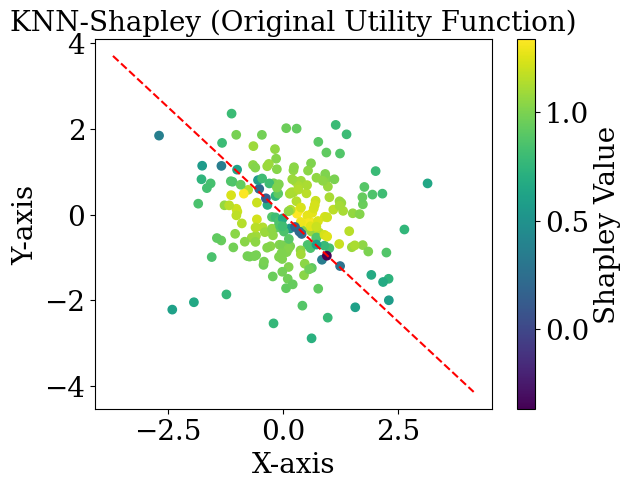

In [8]:
# Extract x and y coordinates
x = x_train[:, 0]
y = x_train[:, 1]

# Plot the points with colors according to the values
plt.scatter(x, y, c=sv_exact, cmap='viridis', marker='o')

# Plot the line y = -x
# Determine the range for x based on your data or desired range
x_line = np.linspace(min(x)-1, max(x)+1, 400)  # 400 points from min(x)-1 to max(x)+1
y_line = -x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label='y = -x')

# Add a colorbar to show the mapping from values to colors
plt.colorbar(label='Shapley Value')

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('KNN-Shapley (Original Utility Function)')

# Display the plot
plt.show()

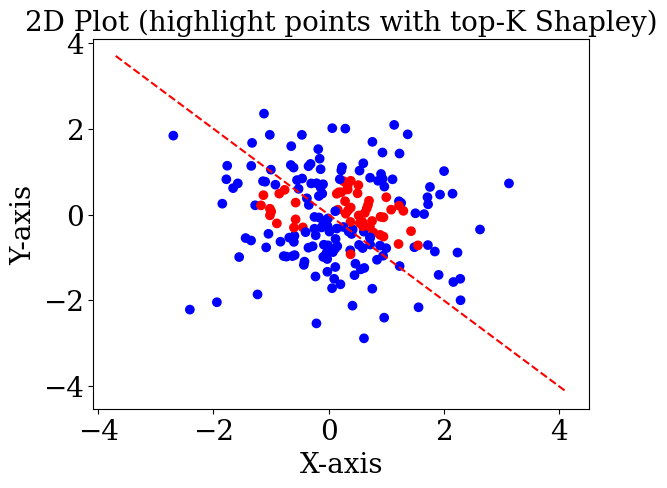

In [9]:
def top_k_indices(arr, k):
    """Return the indices of the highest k values in the array."""
    return np.argsort(arr)[-k:][::-1]


k = 50
topk_sv = top_k_indices(sv_exact, k)

# Create a color array with a default color (e.g., 'blue') for all points
colors = ['blue'] * len(y_train)

# Update the color for those points that are within the index set to a different color (e.g., 'red')
for idx in topk_sv:
  colors[idx] = 'red'

# Extract x and y coordinates
x = x_train[:, 0]
y = x_train[:, 1]

# Plot the x_train with the specified colors
plt.scatter(x, y, c=colors, marker='o')

# Plot the line y = -x
# Determine the range for x based on your data or desired range
x_line = np.linspace(min(x)-1, max(x)+1, 400)  # 400 points from min(x)-1 to max(x)+1
y_line = -x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label='y = -x')

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Plot (highlight points with top-K Shapley)')

# Display the plot
plt.show()

In [10]:
np.linspace(25, 200, 8).astype(int)

array([ 25,  50,  75, 100, 125, 150, 175, 200])

In [11]:
select_result = {}

select_result['sv'] = []

for k in np.linspace(25, 200, 8).astype(int):

  topk_sv = top_k_indices(sv_exact, k)
  acc = get_knn_acc(x_train[topk_sv], y_train[topk_sv], x_val, y_val, K=5, dis_metric='l2')
  select_result['sv'].append(acc)

In [12]:
select_result['random'] = []

for k in np.linspace(25, 200, 8).astype(int):
  rand_ind = np.random.choice(np.arange(200), size=k, replace=False)
  acc = get_knn_acc(x_train[rand_ind], y_train[rand_ind], x_val, y_val, K=5, dis_metric='l2')
  select_result['random'].append(acc)

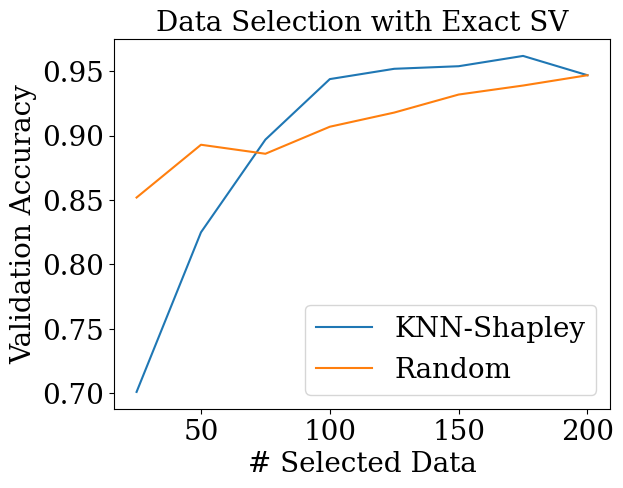

In [13]:
plt.figure()

plt.plot(np.linspace(25, 200, 8).astype(int), select_result['sv'], label='KNN-Shapley')
plt.plot(np.linspace(25, 200, 8).astype(int), select_result['random'], label='Random')

plt.xlabel('# Selected Data')
plt.ylabel('Validation Accuracy')
plt.title('Data Selection with Exact SV')

plt.legend()
plt.show()

## Generate New Test Set k=50

In [14]:
k = 50

topk_sv = top_k_indices(sv_exact, k)

y_val_new = get_knn_pred(x_train[topk_sv], y_train[topk_sv], x_val, y_val, K=5).astype(int)

sv_exact_new = knn_shapley_RJ(x_train, y_train, x_val, y_val_new, K=5)

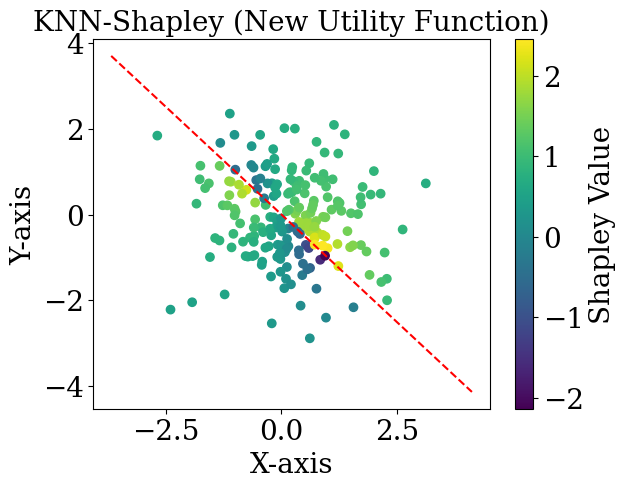

In [15]:
# Extract x and y coordinates
x = x_train[:, 0]
y = x_train[:, 1]

# Plot the points with colors according to the values
plt.scatter(x, y, c=sv_exact_new, cmap='viridis', marker='o')

# Plot the line y = -x
# Determine the range for x based on your data or desired range
x_line = np.linspace(min(x)-1, max(x)+1, 400)  # 400 points from min(x)-1 to max(x)+1
y_line = -x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label='y = -x')

# Add a colorbar to show the mapping from values to colors
plt.colorbar(label='Shapley Value')

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('KNN-Shapley (New Utility Function)')

# Display the plot
plt.show()

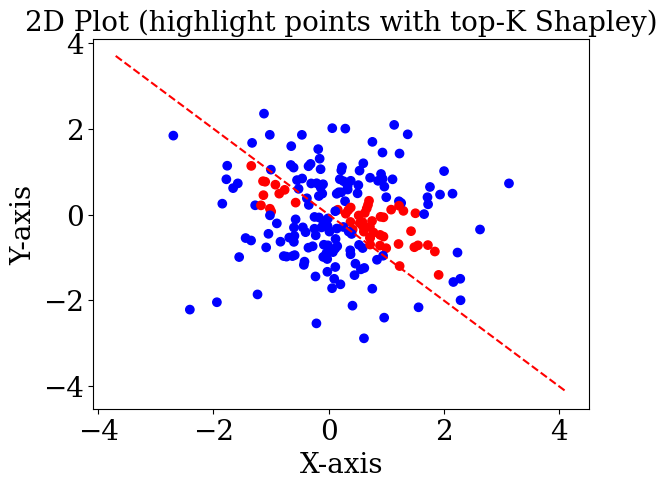

In [16]:
k = 50
topk_sv = top_k_indices(sv_exact_new, k)

# Create a color array with a default color (e.g., 'blue') for all points
colors = ['blue'] * len(y_train)

# Update the color for those points that are within the index set to a different color (e.g., 'red')
for idx in topk_sv:
  colors[idx] = 'red'

# Extract x and y coordinates
x = x_train[:, 0]
y = x_train[:, 1]

# Plot the x_train with the specified colors
plt.scatter(x, y, c=colors, marker='o')

# Plot the line y = -x
# Determine the range for x based on your data or desired range
x_line = np.linspace(min(x)-1, max(x)+1, 400)  # 400 points from min(x)-1 to max(x)+1
y_line = -x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label='y = -x')

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Plot (highlight points with top-K Shapley)')

# Display the plot
plt.show()

In [17]:
select_result = {}

select_result['sv'] = []

for k in np.linspace(25, 200, 8).astype(int):

  topk_sv = top_k_indices(sv_exact_new, k)
  acc = get_knn_acc(x_train[topk_sv], y_train[topk_sv], x_val, y_val_new, K=5, dis_metric='l2')
  select_result['sv'].append(acc)

In [18]:
select_result['random'] = []

for k in np.linspace(25, 200, 8).astype(int):

  rand_ind = np.random.choice(np.arange(200), size=k, replace=False)
  acc = get_knn_acc(x_train[rand_ind], y_train[rand_ind], x_val, y_val_new, K=5, dis_metric='l2')
  select_result['random'].append(acc)

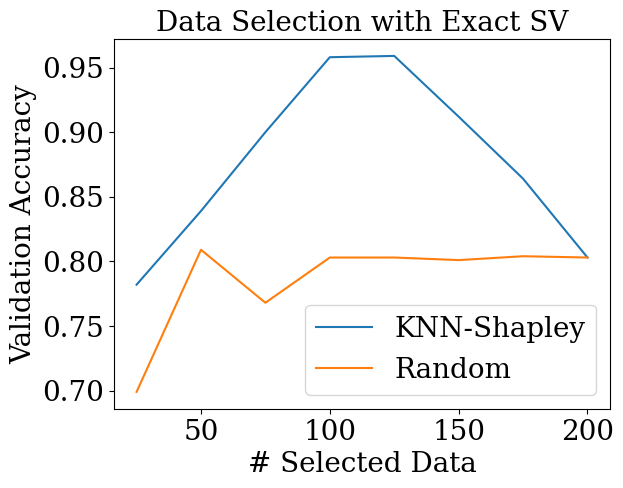

In [19]:
plt.figure()

plt.plot(np.linspace(25, 200, 8).astype(int), select_result['sv'], label='KNN-Shapley')
plt.plot(np.linspace(25, 200, 8).astype(int), select_result['random'], label='Random')

plt.xlabel('# Selected Data')
plt.ylabel('Validation Accuracy')
plt.title('Data Selection with Exact SV')

plt.legend()
plt.show()

In [20]:
import numpy as np
from scipy.stats import spearmanr

# Compute Spearman rank correlation
correlation, p_value = spearmanr(sv_exact, sv_exact_new)
correlation

0.504563114077852

## Generate New Test Set - k=40

In [21]:
for k in range(40, 41):

  topk_sv = top_k_indices(sv_exact, k)

  y_val_new = get_knn_pred(x_train[topk_sv], y_train[topk_sv], x_val, y_val, K=5).astype(int)

  sv_exact_new = knn_shapley_RJ(x_train, y_train, x_val, y_val_new, K=5)

  # Compute Spearman rank correlation
  correlation, p_value = spearmanr(sv_exact, sv_exact_new)
  print(k, correlation)

40 0.4723408085202131


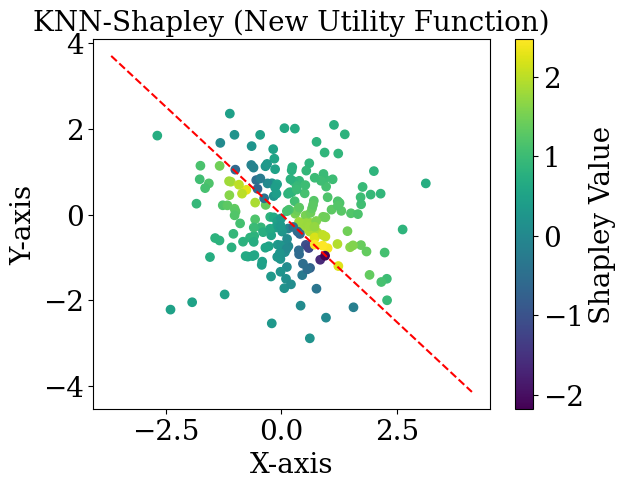

In [22]:
# Extract x and y coordinates
x = x_train[:, 0]
y = x_train[:, 1]

# Plot the points with colors according to the values
plt.scatter(x, y, c=sv_exact_new, cmap='viridis', marker='o')

# Plot the line y = -x
# Determine the range for x based on your data or desired range
x_line = np.linspace(min(x)-1, max(x)+1, 400)  # 400 points from min(x)-1 to max(x)+1
y_line = -x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label='y = -x')

# Add a colorbar to show the mapping from values to colors
plt.colorbar(label='Shapley Value')

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('KNN-Shapley (New Utility Function)')

# Display the plot
plt.show()

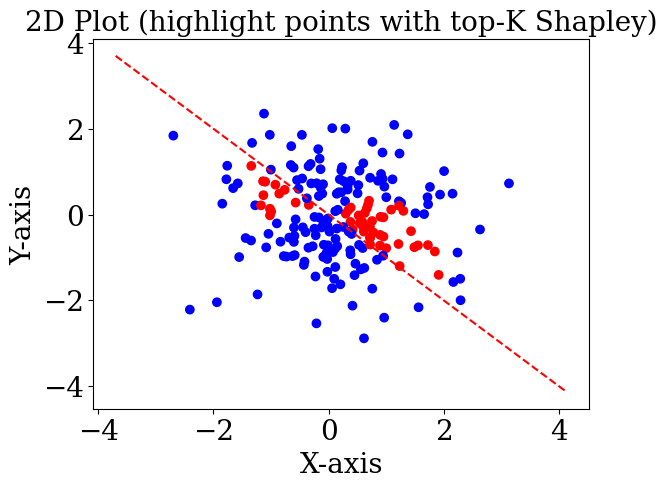

In [23]:
k = 50
topk_sv = top_k_indices(sv_exact_new, k)

# Create a color array with a default color (e.g., 'blue') for all points
colors = ['blue'] * len(y_train)

# Update the color for those points that are within the index set to a different color (e.g., 'red')
for idx in topk_sv:
  colors[idx] = 'red'

# Extract x and y coordinates
x = x_train[:, 0]
y = x_train[:, 1]

# Plot the x_train with the specified colors
plt.scatter(x, y, c=colors, marker='o')

# Plot the line y = -x
# Determine the range for x based on your data or desired range
x_line = np.linspace(min(x)-1, max(x)+1, 400)  # 400 points from min(x)-1 to max(x)+1
y_line = -x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label='y = -x')

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Plot (highlight points with top-K Shapley)')

# Display the plot
plt.show()

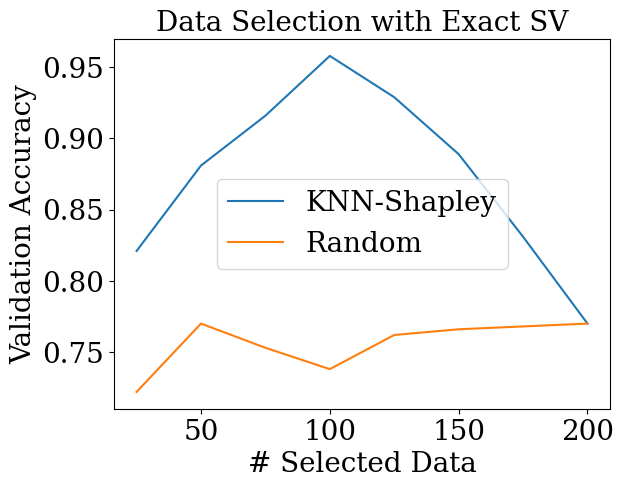

In [24]:
select_result = {}

select_result['sv'] = []

for k in np.linspace(25, 200, 8).astype(int):

  topk_sv = top_k_indices(sv_exact_new, k)
  acc = get_knn_acc(x_train[topk_sv], y_train[topk_sv], x_val, y_val_new, K=5, dis_metric='l2')
  select_result['sv'].append(acc)


select_result['random'] = []

for k in np.linspace(25, 200, 8).astype(int):

  rand_ind = np.random.choice(np.arange(200), size=k, replace=False)
  acc = get_knn_acc(x_train[rand_ind], y_train[rand_ind], x_val, y_val_new, K=5, dis_metric='l2')
  select_result['random'].append(acc)


plt.figure()

plt.plot(np.linspace(25, 200, 8).astype(int), select_result['sv'], label='KNN-Shapley')
plt.plot(np.linspace(25, 200, 8).astype(int), select_result['random'], label='Random')

plt.xlabel('# Selected Data')
plt.ylabel('Validation Accuracy')
plt.title('Data Selection with Exact SV')

plt.legend()
plt.show()

# Verifying Symmetry Axiom

In [25]:
# Implement Dummy Data Point Idea
def shapley_grouptest(utility_array, n_data, n_sample):
  N = n_data + 1
  Z = np.sum([1/k+1/(N-k) for k in range(1, N)])
  q = [1/Z * (1/k+1/(N-k)) for k in range(1, N)]

  A = np.zeros((n_sample, N))
  B = np.zeros(n_sample)

  for t in range(n_sample):
    # Randomly sample size from 1,...,N-1
    size = np.random.choice(np.arange(1, N), p=q)

    # Uniformly sample k data points from N data points
    subset_ind = np.random.choice(np.arange(N), size, replace=False)

    A[t, subset_ind] = 1

    subset_ind = subset_ind[subset_ind < n_data]
    B[t] = utility_array[int(dataind_to_val(subset_ind))]

  C = {}
  for i in range(N):
    for j in range(i+1, N):
      C[(i,j)] = Z*(B.dot(A[:,i] - A[:,j]))/n_sample

  sv_last = 0
  sv_approx = np.zeros(n_data)

  for i in range(n_data):
    sv_approx[i] = C[(i, N-1)] + sv_last

  return sv_approx


def perm_shapley_sampling(utility_array, n_data, target_ind, n_sample):
  marginal_value = []
  n_sample = int(n_sample / 2)

  for _ in range(n_sample):
    perm = np.random.permutation(range(n_data))

    i = (perm==target_ind).nonzero()[0][0]

    team_without = list(perm[:i])
    without_score = utility_array[int(dataind_to_val(team_without))]

    team_with = list(perm[:i+1])
    with_score = utility_array[int(dataind_to_val(team_with))]
    marginal_value.append(with_score - without_score)
  return np.average(marginal_value)



def shapley_permsampling(utility_array, n_data, n_sample):

  n_perm = int(n_sample / n_data)
  if n_perm * n_data < n_sample:
    print('WARNING: n_sample cannot be divided by n_data')

  sv_vector = np.zeros(n_data)

  for _ in range(n_perm):
    perm = np.random.permutation(range(n_data))

    for i in range(0, n_data):
      target_ind = perm[i]
      team_without = list(perm[:i])
      without_score = utility_array[int(dataind_to_val(team_without))]
      team_with = list(perm[:i+1])
      with_score = utility_array[int(dataind_to_val(team_with))]
      sv_vector[target_ind] += (with_score-without_score)

  return sv_vector / n_perm

In [26]:
np.random.seed(45)

X, y = generate_random_data(1000)

n_train = 12

x_train, y_train = select_subset(X, y, class_ratio=0.5, subset_size=n_train)

x_train[-1], y_train[-1] = x_train[-2], y_train[-2]

x_test, y_test = generate_random_data(2000)

utility_array = get_util_func(x_train, y_train, x_test, y_test, method='LR')
sv_exact = np.array( [exact_shapley(utility_array, n_train, i) for i in range(n_train)] )

  0%|          | 0/4096 [00:00<?, ?it/s]

100%|██████████| 4096/4096 [00:06<00:00, 679.26it/s]


In [27]:
print(sv_exact)

[0.03140545 0.06810711 0.05710498 0.0706509  0.00709104 0.03224897
 0.0406452  0.03025161 0.06457179 0.02223725 0.01009286 0.01009286]


In [28]:
shapley_grouptest(utility_array, n_train, n_sample=n_train*1000)

array([0.05333721, 0.09328587, 0.09746383, 0.08947513, 0.00299563,
       0.05645128, 0.03716379, 0.02499714, 0.08449396, 0.07240463,
       0.02878926, 0.00931429])

In [29]:
shapley_permsampling(utility_array, n_train, n_sample=n_train*10000)

array([0.0318147 , 0.0690114 , 0.0577841 , 0.0698979 , 0.0055486 ,
       0.0328206 , 0.0402846 , 0.02975595, 0.0627567 , 0.02302185,
       0.01202485, 0.00977875])

In [30]:
lst_perm = []

for n_perm in [10, 100, 500, 1000, 2000, 5000, 10000]:
  print(n_perm)
  sv_diff_lst = []
  for _ in range(5):
    sv_perm = shapley_permsampling(utility_array, n_train, n_sample=n_train*n_perm)
    sv_diff = np.abs(sv_perm[-2]-sv_perm[-1])
    sv_diff_lst.append(sv_diff)
  lst_perm.append(np.mean(sv_diff_lst))

10
100
500
1000
2000
5000
10000


In [31]:
np.random.seed(22)

lst_gt = []

for n_perm in [10, 100, 500, 1000, 2000, 5000, 10000]:
  print(n_perm)
  sv_diff_lst = []
  for _ in range(5):
    sv_perm = shapley_grouptest(utility_array, n_train, n_sample=n_train*n_perm)
    sv_diff = np.abs(sv_perm[-2]-sv_perm[-1])
    sv_diff_lst.append(sv_diff)
  lst_gt.append(np.mean(sv_diff_lst))

10
100
500
1000
2000
5000
10000


ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

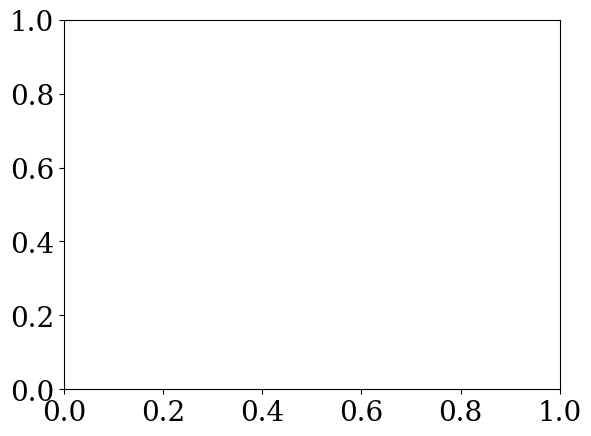

In [32]:
plt.figure()

plt.plot(np.array([10, 100, 500, 1000, 2000, 5000])*n_train, lst_perm, label='Permutation Sampling')
plt.plot(np.array([10, 100, 500, 1000, 2000, 5000])*n_train, lst_gt, label='Group Testing')

plt.yscale("log")

plt.xlabel('# Samples')
plt.ylabel('|ERROR|')
plt.title('Shapley Difference Between Canaries')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()